# Introduction

After creating the model and saving it, we'll now consider some problems to tackle for deployment of our model. There are three main problems to solve:
- Area and No_Rooms relationship. The inputs from these variables have to make sense - there shouldn't be a case where a user inputs studio apartment with 350 meter squared area. We have to inform the user on what values of area and number of rooms make sense.
- Longitude and Latitude. We should bring back Locality and Region for this. People recognize and know names of places better than longitude and latitude coordinate. The option we are going to serve to our user shall be Region and Locality, and we should be able to convert them to Longitude and Latitude in the backends. 

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
apartment = pd.read_csv('Final Dataset.csv')

In [3]:
apartment.head()

,Unnamed: 0,Area,Latitude,Longitude,Jakcheck,Multipurpose_Room,Playground,Basketball,Swim_Pool,Jogging,Restaurant,Electricity,Tennis,Washing_Machine,Fridge,Furnished,Water_Heater,Kitchen,No_Rooms,AnnualPrice
0,0,43.0,-6.226598,106.819159,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,96000000.0
1,1,35.0,-6.192081,106.756061,1,1,1,0,1,1,1,1,0,0,1,0,0,1,2,30000000.0
2,2,53.0,-6.186415,106.757651,1,1,1,0,1,1,1,1,0,1,1,1,1,1,2,70000000.0
3,3,85.0,-6.272637,106.784600,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,576000000.0
4,4,48.0,-6.153652,106.796056,1,1,1,0,1,0,1,1,0,0,0,0,0,0,2,32000000.0


## Area and No_Rooms

In [4]:
df = apartment[['No_Rooms', 'Area']]

<AxesSubplot:xlabel='No_Rooms', ylabel='Area'>

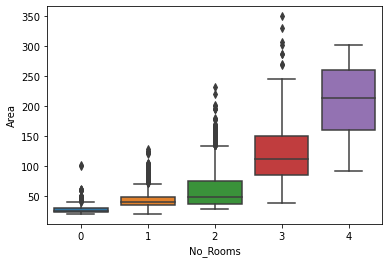

In [5]:
sns.boxplot(x = 'No_Rooms', y = 'Area', data = df)

In [6]:
df[df['No_Rooms'] == 0].describe()

,No_Rooms,Area
count,1055.0,1055.000000
mean,0.0,27.617355
std,0.0,7.256154
min,0.0,20.340000
25%,0.0,23.000000
50%,0.0,26.000000
75%,0.0,30.000000
max,0.0,102.000000


For Studio type apartment units, we'll tell our users that the average area is 27 meter squared. The minimum area is 20 meter squared, and we'll keep the maximum at 100 meter squared.

In [7]:
df[df['No_Rooms'] == 1].describe()

,No_Rooms,Area
count,976.0,976.000000
mean,1.0,45.015338
std,0.0,17.795007
min,1.0,21.000000
25%,1.0,35.000000
50%,1.0,40.000000
75%,1.0,49.000000
max,1.0,129.000000


For apartment units with one bedroom, the average area is 45 meter suqared. The minimum is 21 meter squared, and the maximum is 129 meter squared.

In [8]:
df[df['No_Rooms'] == 2].describe()

,No_Rooms,Area
count,2533.0,2533.000000
mean,2.0,59.662511
std,0.0,28.947977
min,2.0,28.000000
25%,2.0,37.000000
50%,2.0,49.000000
75%,2.0,76.000000
max,2.0,232.000000


For apartment units with two bedrooms, the average area is 59 meter squared. The minimum is 28 meter squared, and the maximum is 232 meter squared.

In [9]:
df[df['No_Rooms'] == 3].describe()

,No_Rooms,Area
count,602.0,602.000000
mean,3.0,121.049502
std,0.0,48.400426
min,3.0,38.000000
25%,3.0,86.000000
50%,3.0,112.000000
75%,3.0,150.000000
max,3.0,350.000000


For apartments with three bedrooms, the average area is 121 meter squared. The minimum is 38 meter squared, while the maximum - I think we'll set it to 300 meter squared. Usually, a three bedroom apartment unit wouldn't have an area larger than units with four bedroom - and in our observation, we see that even the units with four bedrooms and more have a maximum area of 303 meter squared.

In [10]:
df[df['No_Rooms'] == 4].describe()

,No_Rooms,Area
count,17.0,17.000000
mean,4.0,211.352941
std,0.0,65.168955
min,4.0,92.000000
25%,4.0,160.000000
50%,4.0,214.000000
75%,4.0,260.000000
max,4.0,303.000000


For apartment units with four or more bedrooms, the average area is 211 meter squared. The minimum is 92 meter squared, while the maximum is at 300 meter squared.

## Locality, Region, Longitude and Latitude

When each user selects a region and a district, our deployment back-end should be able to cnvert the user's selection into numerical longitude and latitude. We're tackling the problem here by making a nested dictionary of all possible combination of Region and Locality from the raw dataset.

In [11]:
location = pd.read_csv('Cleaned Apartment Data.csv')[['Region', 'Locality', 'Longitude', 'Latitude']]

In [12]:
location.head()

,Region,Locality,Longitude,Latitude
0,Jakarta Selatan,Semanggi,106.819159,-6.226598
1,Jakarta Barat,Kebon Jeruk,106.756061,-6.192081
2,Jakarta Barat,Kedoya,106.757651,-6.186415
3,Jakarta Selatan,Pondok Indah,106.784600,-6.272637
4,Jakarta Barat,Grogol,106.796056,-6.153652


In [13]:
location = location.groupby(['Region', 'Locality']).mean().reset_index()

In [14]:
Coordinate = list()
for i in range(len(location.Longitude)):
    lon = str(location.Longitude[i])
    lat = str(location.Latitude[i])
    point = lon+','+lat
    Coordinate.append(point)
    
location['Coordinate'] = Coordinate

In [15]:
def nested_dict(df):
    if len(df.columns) == 1:
        if df.values.size == 1: return df.values[0][0]
        return df.values.squeeze()
    merged = df.groupby(df.columns[0])
    d = {k: nested_dict(g.iloc[:,1:]) for k,g in merged}
    return d

def lon_finder(dict, region, locality):
    return float(dict[region][locality].split(',')[0])

def lat_finder(dict, region, locality):
    return float(dict[region][locality].split(',')[0])

In [16]:
location['Coordinate'] = Coordinate
location_dict = nested_dict(location[['Region', 'Locality', 'Coordinate']])

In [17]:
#Example
lon_finder(location_dict, 'Jakarta Barat', 'Kebon Jeruk')

106.7592318917747

In [18]:
import pickle
file = open("location_dict.pkl", "wb")
pickle.dump(location_dict, file)
file.close()

In [19]:
#load test
load_dict = open('location_dict.pkl', 'rb')
output = pickle.load(load_dict)
output

{'Bekasi': {'Bekasi': '107.0099,-6.25352',
  'Bekasi Timur': '107.0205,-6.2597',
  'Cikarang': '107.14643636363635,-6.317336363636364',
  'Kalimalang': '107.01410000000004,-6.261266666666668',
  'Lippo Cikarang': '107.1344,-6.3294',
  'Pekayon': '106.9848882352941,-6.250652941176468',
  'Summarecon Bekasi': '106.99899999999998,-6.222399999999997'},
 'Bogor': {'Sentul': '106.8608,-6.5646', 'Tanah Sareal': '106.7827,-6.556'},
 'Depok': {'Cimanggis': '106.89390000000002,-6.4274',
  'Cinere': '106.78712219047623,-6.324632952380951',
  'Margonda': '106.83063030000001,-6.367680849999999'},
 'Jakarta Barat': {'Cengkareng': '106.72808414351887,-6.163089657407412',
  'Daan Mogot': '106.735757,-6.156825',
  'Duri Kosambi': '106.70950675,-6.15417725',
  'Gajah Mada': '106.815172862069,-6.14888651724138',
  'Grogol': '106.79570745762717,-6.154264525423732',
  'Kalideres': '106.70156866666667,-6.135226',
  'Kebon Jeruk': '106.7592318917747,-6.195190961038954',
  'Kedoya': '106.75825603896098,-6.186

In [20]:
location[location['Region']=='Jakarta Selatan']

,Region,Locality,Longitude,Latitude,Coordinate
44,Jakarta Selatan,Bintaro,106.755517,-6.267100,"106.75551718000001,-6.267100440000002"
45,Jakarta Selatan,Casablanca,106.842976,-6.223885,"106.84297631355945,-6.223885008474585"
46,Jakarta Selatan,Cilandak,106.801401,-6.285317,"106.801401,-6.2853173333333325"
47,Jakarta Selatan,Dharmawangsa,106.804426,-6.258746,"106.804426,-6.2587459999999995"
48,Jakarta Selatan,Epicentrum,106.834400,-6.217500,"106.8344,-6.2175"
49,Jakarta Selatan,Fatmawati,106.795363,-6.300475,"106.79536294594594,-6.300475081081085"
50,Jakarta Selatan,Gandaria,106.787489,-6.245341,"106.78748907142857,-6.245341321428569"
51,Jakarta Selatan,Gatot Subroto,106.837295,-6.240375,"106.837295,-6.240375"
52,Jakarta Selatan,Kalibata,106.851444,-6.257154,"106.85144416438337,-6.257153876712333"
53,Jakarta Selatan,Kebagusan,106.835418,-6.307531,"106.83541799999996,-6.307531000000002"


In [ ]:
df = pd.DataFrame(columns = ['No_Rooms'])

In [ ]:
No_Rooms = list()
No_Rooms.append(1)

In [ ]:
df['No_Rooms'] = No_Rooms

In [ ]:
df

In [ ]:
import joblib
xgb = joblib.load('xgboost_tuned.joblib.dat')

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
xgb.predict(test)[0]

In [ ]:
test.Jakcheck[0] = (1+1==2)

In [ ]:
xgb.predict(test)

In [23]:
apartment

,Unnamed: 0,Area,Latitude,Longitude,Jakcheck,Multipurpose_Room,Playground,Basketball,Swim_Pool,Jogging,Restaurant,Electricity,Tennis,Washing_Machine,Fridge,Furnished,Water_Heater,Kitchen,No_Rooms,AnnualPrice
0,0,43.0,-6.226598,106.819159,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,96000000.0
1,1,35.0,-6.192081,106.756061,1,1,1,0,1,1,1,1,0,0,1,0,0,1,2,30000000.0
2,2,53.0,-6.186415,106.757651,1,1,1,0,1,1,1,1,0,1,1,1,1,1,2,70000000.0
3,3,85.0,-6.272637,106.784600,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,576000000.0
4,4,48.0,-6.153652,106.796056,1,1,1,0,1,0,1,1,0,0,0,0,0,0,2,32000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,5178,36.0,-6.243400,106.993400,0,0,1,0,1,0,0,1,0,1,1,1,0,1,2,36000000.0
5179,5179,32.0,-6.294400,106.664000,0,1,1,0,1,0,0,1,0,0,1,1,1,1,0,60000000.0
5180,5180,83.0,-6.216540,106.829330,1,1,1,0,1,1,1,1,0,1,1,1,1,1,2,250000000.0
5181,5181,68.0,-6.202296,106.801738,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,108000000.0


In [24]:
cleaned = pd.read_csv('Cleaned Apartment Data.csv')

In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = LabelEncoder()
encoder.fit_transform(cleaned.Region)

array([5, 3, 3, ..., 5, 4, 6])